<a href="https://colab.research.google.com/github/ArifAygun/Magnimind-Jan2023-Assignments/blob/main/AA_Feature_Engineering_Assignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Feature Engineering Assignment**

#**Objectives:**

You've constructed some potentially useful and business-relevant features, derived from summary statistics, for each of the states you're concerned with. You've explored many of these features in turn and found various trends. Some states are higher in some but not in others. Some features will also be more correlated with one another than others.

One way to disentangle this interconnected web of relationships is via principal components analysis (PCA). This technique will find linear combinations of the original features that are uncorrelated with one another and order them by the amount of variance they explain. You can use these derived features to visualize the data in a lower dimension (e.g. 2 down from 7) and know how much variance the representation explains. You can also explore how the original features contribute to these derived features.

The basic steps in this process are:

1. scale the data and verify the scaling
2. fit the PCA transformation (learn the transformation from the data)
3. Draw scree plot
4. Find the optimum number of components
5. Draw the biplot and interpret the relationship between features and components
6. Find the exact correlation between components and features using loading

##**1. Sourcing and Loading**

### **1.1. Importing Libraries**

In [61]:
import pandas as pd
import numpy as np

###**1.2. Loading the data**

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import pandas as pd
import os

def file_locator(file_name):
  main_dir = os.getcwd()

  for dir, folder, files in os.walk(main_dir):
    for file in files:
      if file == file_name:
        file_path = os.path.join(dir,file)
  return file_path

file_path = file_locator('ski_resort_data.csv')
df = pd.read_csv(file_path)
df.head()

,Name,Region,state,summit_elev,vertical_drop,base_elev,trams,fastEight,fastSixes,fastQuads,...,LongestRun_mi,SkiableTerrain_ac,Snow Making_ac,daysOpenLastYear,yearsOpen,averageSnowfall,AdultWeekday,AdultWeekend,projectedDaysOpen,NightSkiing_ac
0,Alyeska Resort,Alaska,Alaska,3939,2500,250,1,0.0,0,2,...,1.0,1610.0,113.0,150.0,60.0,669.0,65.0,85.0,150.0,550.0
1,Eaglecrest Ski Area,Alaska,Alaska,2600,1540,1200,0,0.0,0,0,...,2.0,640.0,60.0,45.0,44.0,350.0,47.0,53.0,90.0,NaN
2,Hilltop Ski Area,Alaska,Alaska,2090,294,1796,0,0.0,0,0,...,1.0,30.0,30.0,150.0,36.0,69.0,30.0,34.0,152.0,30.0
3,Arizona Snowbowl,Arizona,Arizona,11500,2300,9200,0,0.0,1,0,...,2.0,777.0,104.0,122.0,81.0,260.0,89.0,89.0,122.0,NaN
4,Sunrise Park Resort,Arizona,Arizona,11100,1800,9200,0,NaN,0,1,...,1.2,800.0,80.0,115.0,49.0,250.0,74.0,78.0,104.0,80.0


## **2. Cleaning & Transforming**

###**2.1. Exploring the data** 

In [64]:
df.shape

(330, 27)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               330 non-null    object 
 1   Region             330 non-null    object 
 2   state              330 non-null    object 
 3   summit_elev        330 non-null    int64  
 4   vertical_drop      330 non-null    int64  
 5   base_elev          330 non-null    int64  
 6   trams              330 non-null    int64  
 7   fastEight          164 non-null    float64
 8   fastSixes          330 non-null    int64  
 9   fastQuads          330 non-null    int64  
 10  quad               330 non-null    int64  
 11  triple             330 non-null    int64  
 12  double             330 non-null    int64  
 13  surface            330 non-null    int64  
 14  total_chairs       330 non-null    int64  
 15  Runs               326 non-null    float64
 16  TerrainParks       279 non

###**2.2. Cleaning the data**

In [66]:
missing = pd.concat([df.isnull().sum(), 100*df.isnull().mean()], axis=1)
missing.columns=['count', 'Percentage']
missing.sort_values(by='count', ascending=False)

,count,Percentage
fastEight,166,50.303030
NightSkiing_ac,143,43.333333
AdultWeekday,54,16.363636
AdultWeekend,51,15.454545
daysOpenLastYear,51,15.454545
TerrainParks,51,15.454545
projectedDaysOpen,47,14.242424
Snow Making_ac,46,13.939394
averageSnowfall,14,4.242424
LongestRun_mi,5,1.515152


Since 'fastEight' and 'NightSkiing_ac' variables have many missing values, I am dropping them.
'AdultWeekday' and 'AdultWeekend' (prices) are my target variable but similar to each other. Since 'AdultWeekday' has more missing values than 'AdultWeekend', I will keep only 'AdultWeekend' for further work with data. 

In [67]:
df2 = df.drop(['fastEight', 'NightSkiing_ac', 'AdultWeekday'], axis=1)

In [68]:
df2.shape

(330, 24)

In [69]:
df2['Name'].value_counts().head()

Crystal Mountain    2
Alyeska Resort      1
Brandywine          1
Boston Mills        1
Alpine Valley       1
Name: Name, dtype: int64

In [70]:
df2[df2['Name'] == 'Crystal Mountain']

,Name,Region,state,summit_elev,vertical_drop,base_elev,trams,fastSixes,fastQuads,quad,...,Runs,TerrainParks,LongestRun_mi,SkiableTerrain_ac,Snow Making_ac,daysOpenLastYear,yearsOpen,averageSnowfall,AdultWeekend,projectedDaysOpen
104,Crystal Mountain,Michigan,Michigan,1132,375,757,0,0,1,3,...,58.0,3.0,0.3,102.0,96.0,120.0,63.0,132.0,64.0,135.0
295,Crystal Mountain,Washington,Washington,7012,3100,4400,1,2,2,1,...,57.0,1.0,2.5,2600.0,10.0,NaN,57.0,486.0,99.0,NaN


There are two different ski resaurts with the same name 'Crystal Mountain'

## **3. Scaling the data & Verify the scaling**

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [72]:
ski=df2.select_dtypes(exclude='object')

In [73]:
ski.dropna(inplace=True)

In [74]:
len(ski.columns)

21

In order to process our data, we need to convert it into array:

In [75]:
X=ski.values

In [76]:
X=StandardScaler().fit_transform(ski)

## **4. Fitting the PCA transformation (Learning the transformation from the data)**

In [77]:
pca=PCA(n_components=16)

In [90]:
principalComponents=pca.fit_transform(X)
exp_var=pca.explained_variance_ratio_
cumsum_var=np.cumsum(np.round(pca.explained_variance_ratio_,decimals=4)*100)
print(exp_var)
print('-'*70)
print(cumsum_var)

[0.38927686 0.12833795 0.0672121  0.05980761 0.05744413 0.04614131
 0.04239612 0.03738647]
----------------------------------------------------------------------
[38.93 51.76 58.48 64.46 70.2  74.81 79.05 82.79]


## **5. Drawing scree plot**

Text(0, 0.5, '% of Variance Explained')

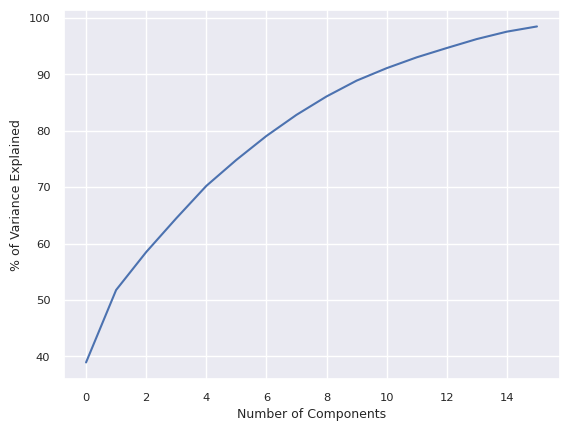

In [79]:
plt.plot(cumsum_var)
plt.xlabel('Number of Components')
plt.ylabel('% of Variance Explained')

In [80]:
pd.DataFrame(principalComponents)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2.868958,-1.690913,-1.283404,-1.771192,0.214376,-0.559467,0.674219,-1.928165,0.058953,1.513192,2.627222,1.725933,1.128085,1.056229,-0.803131,0.067109
1,-1.692175,-1.884649,2.057647,-1.475743,0.844382,-0.280479,0.320390,0.844273,-0.396328,0.915949,0.568405,1.718867,0.271178,0.355144,-0.021708,0.289736
2,-2.368053,-0.837743,-1.610904,-0.001809,-0.405922,-1.409972,1.530091,-0.782317,0.883526,-0.136488,-0.321174,-0.509525,-0.493655,0.070584,0.806254,0.350135
3,2.556991,-1.654131,0.101134,2.094891,-0.837226,2.066728,0.377161,0.261359,-1.396092,-0.341004,0.046915,0.487664,-0.772660,0.247562,-0.189714,-0.234548
4,1.184262,-2.535673,0.212599,0.448491,-1.317949,-0.780288,-0.850580,0.858503,-1.455751,-0.196045,0.313807,-0.248550,-0.552570,-0.185635,-0.211994,-0.145403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,-1.290822,-0.790435,-0.385710,-1.115200,1.266284,0.240485,0.409306,1.304021,0.212461,0.223031,0.664123,-0.079840,0.965592,-0.447087,0.539924,0.183959
163,-1.088837,1.176298,-1.901226,0.304081,0.545255,0.825306,-1.043823,-0.252479,0.285684,-0.483113,0.683971,-0.065612,-0.260995,-0.521273,0.143502,-0.038520
164,-1.877088,-2.455798,0.263492,0.501151,-0.225242,0.295620,0.380820,-0.434883,-0.598826,-0.654143,0.075475,-1.396820,-0.225537,-0.465205,0.171578,-0.144368
165,-1.616027,-2.838790,1.601234,0.536604,-0.119600,1.324562,-1.205539,-0.561696,-0.520134,0.157388,0.797736,0.196579,0.476525,-0.222758,-0.247474,0.076515


## **6. Finding the Optimum Number of Components**

In [81]:
pd.DataFrame(principalComponents[:,:5])

,0,1,2,3,4
0,2.868958,-1.690913,-1.283404,-1.771192,0.214376
1,-1.692175,-1.884649,2.057647,-1.475743,0.844382
2,-2.368053,-0.837743,-1.610904,-0.001809,-0.405922
3,2.556991,-1.654131,0.101134,2.094891,-0.837226
4,1.184262,-2.535673,0.212599,0.448491,-1.317949
...,...,...,...,...,...
162,-1.290822,-0.790435,-0.385710,-1.115200,1.266284
163,-1.088837,1.176298,-1.901226,0.304081,0.545255
164,-1.877088,-2.455798,0.263492,0.501151,-0.225242
165,-1.616027,-2.838790,1.601234,0.536604,-0.119600


In [82]:
pca=PCA(n_components=8)

In [92]:
principalComponents=pca.fit_transform(X)
exp_var=pca.explained_variance_ratio_
cumsum_var=np.cumsum(np.round(pca.explained_variance_ratio_,decimals=4)*100)
print(exp_var)
print('-'*70)
print(cumsum_var)

[0.38927686 0.12833795 0.0672121  0.05980761 0.05744413 0.04614131
 0.04239612 0.03738647]
----------------------------------------------------------------------
[38.93 51.76 58.48 64.46 70.2  74.81 79.05 82.79]


- To interpret, first and second principal components explain nearly 51% of the total variance and first 8 components explain over 80% of the total variance in ski data.
- We can visualize scree plot in a different way. This time scree plot is used to access components which explains the most of variability in the data. It represents values in descending order.

Text(0, 0.5, 'Explained of Variance')

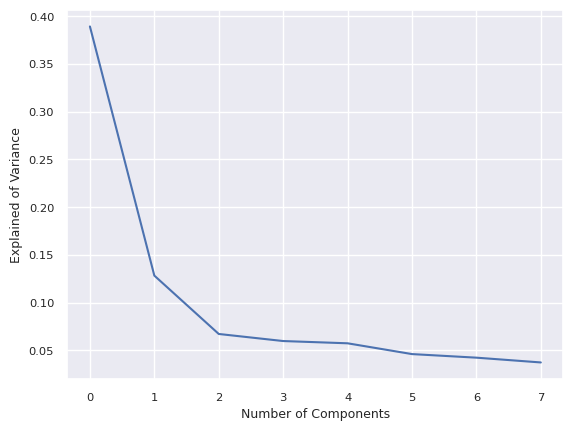

In [84]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained of Variance')

- Accordingly, the first principal component explains over 35% of the variance, second one accounts for nearly 13% of the variance.

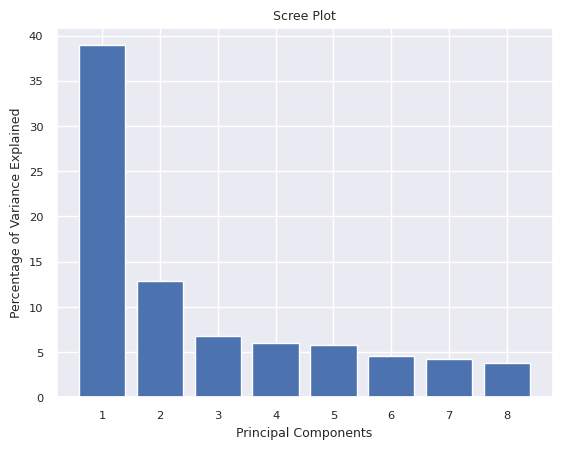

In [85]:
percent_variance=np.round(pca.explained_variance_ratio_*100,decimals=2)
plt.bar(x=range(1,9),height=percent_variance,tick_label=np.arange(1,9,1))
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

## **7. Drawing the biplot & Interpreting the relationship between features and components**

In [86]:
X=pd.DataFrame(X,columns=ski.columns)

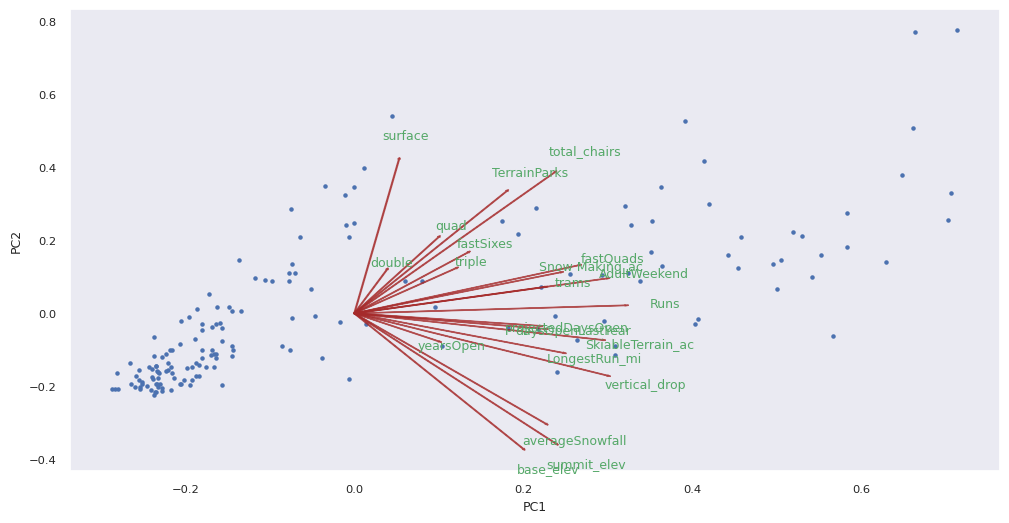

In [97]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig = plt.figure(figsize=(12,6), dpi=100)
    plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'brown',alpha = 0.75)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
myplot(np.array(X)[:,0:2],np.transpose(pca.components_[0:2,:]),list(X.columns))
plt.show()

## **8. Finding the exact correlation between components and features using loading**

In [88]:
loadings = pca.components_.T*np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3', 'PC4','PC5', 'PC6','PC7', 'PC8'], index=ski.columns)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
summit_elev,0.684667,-0.588796,0.131257,0.250259,-0.093777,-0.027656,-0.053914,0.012229
vertical_drop,0.857893,-0.280741,0.132676,-0.126068,-0.025259,-0.044468,0.038515,0.028648
base_elev,0.572953,-0.611493,0.126506,0.336117,-0.104759,-0.018943,-0.074472,0.012859
trams,0.645194,0.119207,0.244580,-0.340553,-0.129520,0.048843,0.098380,-0.130775
fastSixes,0.385446,0.275277,0.108938,0.402593,-0.236928,0.385668,0.545861,0.141978
fastQuads,0.760113,0.217016,0.129255,-0.272184,-0.072576,-0.128830,-0.037215,-0.221499
quad,0.286170,0.344730,-0.527299,-0.333344,-0.148755,0.158676,-0.323995,0.111316
triple,0.344629,0.203813,-0.005984,0.462152,-0.423401,-0.262876,-0.417381,0.273747
double,0.110849,0.198047,0.274248,0.115355,0.835812,-0.160143,0.007011,0.341882
surface,0.151749,0.696321,0.141240,0.268682,0.024496,-0.099966,0.021508,-0.481058


<Axes: >

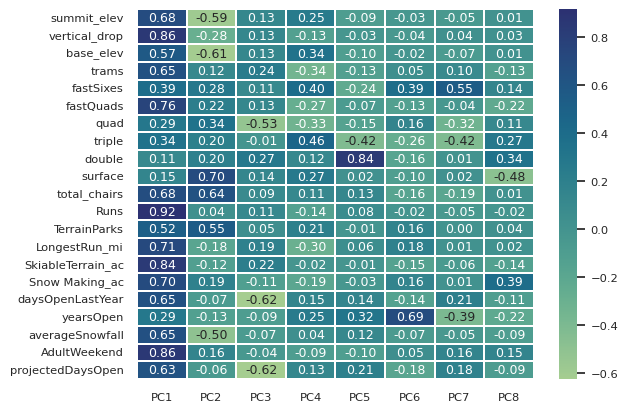

In [98]:
sns.heatmap(loading_matrix, annot=True, fmt=".2f", linewidth=.25, cmap="crest")

## **9. Conclusion**

- We can see that 'summit_elev' has great explanatory power on PC1 in the sense that PC1 and 'summit_elev' variable has a correlation coefficient of 68%, but 'summit_elev' and PC2 has negatively correlated and the correlation between these two is nearly -59%.

- 'AdultWeekend' has also high correlation with PC1 - 86% and low correlation with PC2 - 16%.

- Moreover, interestingly, 'Runs' has the highest correlation with PC1.